In [1]:
import math
from mxnet import gluon, np, npx 
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

#### Generating the Dataset

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w=np.zeros(max_degree)
true_w[0:4]=np.array([5,1.2,-3.4,5.6])

[15:52:12] /home/mertins/Desenvolvimento/C/Terceiros/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


In [3]:
features=np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:,i]/=math.gamma(i+1)
labels=np.dot(poly_features,true_w)
labels+=np.random.normal(scale=0.1,size=labels.shape)


In [4]:
features[:2],poly_features[:2,:],labels[:2]

(array([[ 1.2546344],
        [-0.074684 ]]),
 array([[ 1.00000000e+00,  1.25463438e+00,  7.87053704e-01,
          3.29154879e-01,  1.03242256e-01,  2.59062573e-02,
          5.41714672e-03,  9.70934110e-04,  1.52270906e-04,
          2.12271461e-05,  2.66323082e-06,  3.03761908e-07,
          3.17591784e-08,  3.06508885e-09,  2.74683276e-10,
          2.29751392e-11,  1.80158742e-12,  1.32960808e-13,
          9.26762210e-15,  6.11972411e-16],
        [ 1.00000000e+00, -7.46840015e-02,  2.78885011e-03,
         -6.94274931e-05,  1.29628086e-06, -1.93622878e-08,
          2.41008852e-10, -2.57135784e-12,  2.40049103e-14,
         -1.99198088e-16,  1.48769105e-18, -1.01006112e-20,
          6.28628425e-23, -3.61142174e-25,  1.92653873e-27,
         -9.59210838e-30,  4.47735601e-32, -1.96698179e-34,
          8.16122593e-37, -0.00000000e+00]]),
 array([5.719606, 4.884226]))

##### Training and testing the model

In [5]:
def evaluate_loss(net,data_iter,loss):
    metric=d2l.Accumulator(2)
    for X,y in data_iter:
        l=loss(net(X),y)
        metric.add(l.sum(),d2l.size(l))
    return metric[0]/metric[1]

In [6]:
def train(train_features, test_features, train_labels,test_labels,num_epochs=400):
    loss=gluon.loss.L2Loss()
    net=nn.Sequential()
    net.add(nn.Dense(1,use_bias=False))
    net.initialize()
    batch_size=min(10,train_labels.shape[0])
    train_iter=d2l.load_array((train_features,train_labels),batch_size)
    test_iter=d2l.load_array((test_features,test_labels),batch_size,is_train=False)
    trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.01})
    animator=d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',
        xlim=[1,num_epochs],ylim=[1e-3,1e2],
        legend=['train','test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net,train_iter,loss,trainer)
        if epoch==0 or (epoch+1)%20 ==0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),
                                  evaluate_loss(net,test_iter,loss)))
    print('weight:',net[0].weight.data().asnumpy())

weight: [[ 5.0059657  1.2813454 -3.3993094  5.4674373]]


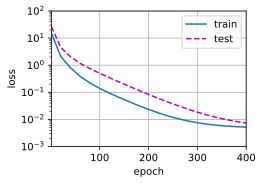

In [7]:
train(poly_features[:n_train,:4],poly_features[n_train:,:4],
    labels[:n_train],labels[n_train:])

#### Linear Function Fitting (Underfitting)

weight: [[2.7411408 4.0261164]]


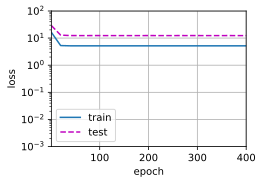

In [8]:
train(poly_features[:n_train,:2],poly_features[n_train:,:2],
        labels[:n_train],labels[n_train:])

#### Higher-Order Polynomial Function Fitting(Overfitting)

weight: [[ 4.9771538e+00  1.3443980e+00 -3.3260758e+00  5.0898647e+00
  -1.3977952e-01  1.1807799e+00  1.9003810e-01  9.4623096e-02
   4.7359532e-03 -8.4558856e-03 -5.6237444e-02 -2.7618356e-02
  -1.2856015e-02  3.8526412e-02 -3.7482731e-02  5.9669312e-02
  -5.1452056e-02 -2.4456521e-02 -6.2520199e-02  6.3401900e-02]]


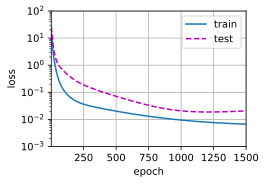

In [9]:
train(poly_features[:n_train,:],poly_features[n_train:,:],
        labels[:n_train],labels[n_train:],num_epochs=1500)